# Predicting Life Expectancy - Data Preprocessing and Modeling

In this notebook, we will focus on the next steps of our data analysis pipeline: Preprocessing and Regression Modeling. After having explored our dataset in the previous notebook, we are now ready to prepare our data for modeling and then build our regression model.

The notebook is structured as follows:

-  **Data Preprocessing**: We will start by preparing our data for modeling. This includes handling categorical variables (if any), scaling numerical features, and splitting our data into training and testing sets.

-  **Regression using Scikit-Learn**: 

3. **Model Training**: Once we have selected a model, we will train it on our data. This involves feeding our training data into the model and allowing it to learn from it.

4. **Model Evaluation**: After our model has been trained, we will evaluate its performance on our testing data. This will give us an idea of how well our model is likely to perform on unseen data.

-  **Regression using Statsmodels**: 


By the end of this notebook, we will have a trained and evaluated baseline regression model ready for further iimprovement or analysis.

For more info see the following articles:

- https://medium.com/@h.jurza/chaos-to-order-data-pre-processing-for-machine-learning-mastery-9921345ba7d0
- https://medium.com/@h.jurza/missing-data-no-problem-techniques-for-handling-incomplete-datasets-2a1e48118445
- https://medium.com/@h.jurza/how-to-build-a-machine-learning-model-ab8baf9e5dd8
- https://medium.com/@h.jurza/an-overview-of-the-data-science-lifecycle-72b3e082296

# Import packages

In [92]:
# General packages
import pandas as pd
import numpy as np

# Pre-processing and modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt

# Set pandas to display all columns in a dataframe
pd.set_option('display.max_columns', None)

# Define Useful Functions

In [93]:
def format_dataframe_columns(df_in):
    """formats dataframe column names by removing spaces, special characters and makes lowercase"""

    import re

    def rename_col(old_col):
        # Make column str type and strip training and leading whitespace
        new_col = str(old_col).strip() 

        # Replace multiple spaces with a single space
        new_col = re.sub(r'\s+', ' ', new_col)

        # Replace spaces, hyphens and slashes with underscore
        new_col = new_col.replace(' ','_')
        new_col = new_col.replace('-','_')
        new_col = new_col.replace('/','_')
        new_col = new_col.replace('\\','_')

        # Remove special characters
        new_col = re.sub(r'[?*!&()]', '', new_col)

        # Make all lowercase
        new_col = new_col.lower()

        return new_col

    df_out = df_in.copy()

    # Get list of dataframe columns
    df_cols_old = df_out.columns

    # Make list of new col names, then put into replacement dict
    df_cols_new = [rename_col(old_col) for old_col in df_cols_old]
    replacement_dict = dict(zip(df_cols_old, df_cols_new))

    # Rename df cols with new col names
    df_out = df_out.rename(columns=(replacement_dict))

    return df_out

# Read Data

In [94]:
# Read data
df = pd.read_csv('data/Life Expectancy Data.csv')

# Format dataframe columns to be lowercase and separated by underscores (for visual consistency)
df = format_dataframe_columns(df)

# Preview data
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


# 1. Data Pre-processing

## 1.1 Correcting data types and identifying feature types
- We know from out EDA that year was incorrectly identified as a numeric variable. We will fix this
- We will then create lists of our categorical and numeric variables

In [114]:
# Correcting data types
#============================

# Convert the 'year' field from float to int
df['year'] = df['year'].astype('int')

# Update our categrical and numeric variable lists as we will use them later
num_vars = df.select_dtypes(include=['float64', 'int64']).columns
cat_vars = df.select_dtypes(include=['object']).columns

## 1.2 Dealing with missing values
- We know from our EDA that there were no missing values in categorical columns, but there were some for our numeric cols
- I have included the code for how to deal with categorical missing values for reference.
- We will then double check to make sure all missing values have been dealt with

In [115]:
# Imputing missing values:
#============================

# Create an imputer for categorical data
cat_imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values in categorical columns
df[cat_vars] = cat_imputer.fit_transform(df[cat_vars])

# Create an imputer for numerical data
num_imputer = SimpleImputer(strategy='mean')

# Impute missing values in numerical columns
df[num_vars] = num_imputer.fit_transform(df[num_vars])

# Check for missing values in the DataFrame
#============================================
missing_values = df.isnull().sum()

missing_values

country                            0
year                               0
status                             0
life_expectancy                    0
adult_mortality                    0
infant_deaths                      0
alcohol                            0
percentage_expenditure             0
hepatitis_b                        0
measles                            0
bmi                                0
under_five_deaths                  0
polio                              0
total_expenditure                  0
diphtheria                         0
hiv_aids                           0
gdp                                0
population                         0
thinness_1_19_years                0
thinness_5_9_years                 0
income_composition_of_resources    0
schooling                          0
dtype: int64

## 1.3 Defining the target  and features

### Target

The target variable, also known as the dependent variable, is the variable that we want to predict or forecast. 

- We know from our EDA that our target variable could be the 'Life Expectancy' column, as our main goal is to predict life expectancy based on other features in the dataset.

### Features

Features are the variables we provide to the model to make predictions. The selection of these features requires an understanding of the problem at hand. 

In our case, we aim to predict a country's life expectancy based on various metrics.

- We've decided not to include the 'country' field as a feature. 

- We assume that life expectancy is to be predicted based on specific metrics that capture the health, economic, and lifestyle conditions of a country, rather than the country's identity itself.

- Including the 'country' field could lead to the model learning the specific life expectancy for each country, rather than understanding the underlying relationship between the conditions in a country and its life expectancy. This could result in overfitting, where the model performs well on the training data but poorly on unseen data. It's akin to the model 'memorising' the life expectancy for each country, which is not what we want.

- We want our model to generalise well and predict life expectancy based on the provided metrics, regardless of the country. This approach makes our model more versatile and applicable to any country, even those not included in the training data.

**Other reasons for excluding features:**

- **Bias and Discrimination**: Including features such as gender, race, or age can lead to unwanted bias in our model's predictions. If these features are used to make decisions that negatively impact certain groups more than others, it can lead to discrimination. For instance, if we're building a job recommendation model, including gender as a feature might lead the model to recommend certain jobs more to one gender than the other, reinforcing existing stereotypes.

- **Irrelevant Data**: Exclude features that don't contribute to the target variable to prevent model complexity and performance decrease.
- **Redundant Data**: Avoid features that are highly correlated with others to prevent multicollinearity and model instability.
- **Noisy Data**: Exclude features with high noise levels to improve model accuracy.
- **Data Leakage**: Avoid features that include future information to prevent overfitting and poor performance on unseen data.
- **High Dimensionality**: Limit the number of features to avoid the curse of dimensionality and model complexity.

The goal is to build a model that generalises well to unseen data, so sometimes less is more when choosing input features.
Feature selection is an art of its own, and there is much more to it, however it's good to know the above context for now.

## X and y

In the context of machine learning, `X` and `y` are conventional notations used to represent the feature matrix and the target vector, respectively.

`X` is a matrix that contains the features or independent variables. 

`y` is a vector that contains the target or dependent variable. 

In [116]:
# Define your target variable
target_variable = 'life_expectancy'

# Define feature variables
feature_variables = ['year', 'status', 'adult_mortality',
                     'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
                     'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure',
                     'diphtheria', 'hiv_aids', 'gdp', 'population', 'thinness_1_19_years',
                     'thinness_5_9_years', 'income_composition_of_resources', 'schooling']

# Split the data into features (X) and target (y)
X = df[feature_variables]
y = df[target_variable]


## 1.4 One-Hot Encoding

One-hot encoding is a process of converting categorical data variables so they can be provided to machine learning algorithms to improve predictions. It is required for the proper functioning of many machine learning algorithms, as they expect numerical input.

With one-hot-encoding, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0. Each integer value is represented as a binary vector.

In our dataset, we will one-hot-encode the following columns:
- Status (2 unique values = 2 new columns in our dataframe)


There are several methods that can be used for one-hot encoding in Python. Here are a two of the most common:

1. **Pandas `get_dummies` function**: This is a simple and convenient function for one-hot encoding. It converts categorical variable(s) into dummy/indicator variables.

    ```python
    df_encoded = pd.get_dummies(df, columns=['column_name'])
    ```

2. **Scikit-learn's `OneHotEncoder`**: This is a more flexible tool that can transform data directly into sparse matrices, which can be more efficient for models to use. It can also handle unseen categories.

    ```python
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder()
    df_encoded = encoder.fit_transform(df[['column_name']])
    ```

In [117]:
# One-hot encode the 'status' feature
X_encoded = pd.get_dummies(X, columns=['status'], drop_first=False)

#preview the new encoded feature dataframe
X_encoded

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,status_Developed,status_Developing
0,2015,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,83.0,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,0,1
1,2014,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,86.0,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,0,1
2,2013,268.0,66.0,0.01,73.219243,64.0,430.0,18.1,89.0,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,0,1
3,2012,272.0,69.0,0.01,78.184215,67.0,2787.0,17.6,93.0,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,0,1
4,2011,275.0,71.0,0.01,7.097109,68.0,3013.0,17.2,97.0,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,2004,723.0,27.0,4.36,0.000000,68.0,31.0,27.1,42.0,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2,0,1
2934,2003,715.0,26.0,4.06,0.000000,7.0,998.0,26.7,41.0,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5,0,1
2935,2002,73.0,25.0,4.43,0.000000,73.0,304.0,26.3,40.0,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0,0,1
2936,2001,686.0,25.0,1.72,0.000000,76.0,529.0,25.9,39.0,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8,0,1


## 1.5 Split into Training and Testing Set

Now that we have a dataframe with no missing values, and all numeric values, we can proceed to create a training and testing set. 

The purpose of creating these sets is to prepare our data for the two main phases of machine learning: **training** and **evaluation**. 

- The **training set** is used to train our machine learning model. During this phase, the model learns to make predictions by finding patterns in the training data. The model's goal is to minimize the difference between its predictions and the actual values in the training set.

- The **testing set** is used to evaluate the performance of our trained model. It provides an unbiased assessment of the model's performance because the model has never seen this data during training. This allows us to understand how well the model is likely to perform on unseen data in the future.

To create these sets, we typically split our dataset into two parts. A common practice is to use 70-80% of the data for training and the remaining 20-30% for testing. This can be easily done using the `train_test_split` function from the `sklearn.model_selection` module:

```python
from sklearn.model_selection import train_test_split

# Assuming 'target_variable' is the column we want to predict
X = df.drop('target_variable', axis=1)
y = df['target_variable']
```


When we use the `train_test_split` function, we end up with four datasets:

1. `X_train`: This is the portion of the feature matrix `X` that we use to train our model. It contains 70-80% of the samples, depending on the `test_size` parameter we set.

2. `X_test`: This is the portion of the feature matrix `X` that we use to test our model. It contains the remaining 20-30% of the samples.

3. `y_train`: This is the portion of the target vector `y` that corresponds to `X_train`.

4. `y_test`: This is the portion of the target vector `y` that corresponds to `X_test`.

The `train_test_split` function ensures that the samples in `X_train` and `X_test` are randomly selected, which helps to ensure that our training and testing sets are representative of the overall dataset.

In [118]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Print the shape of our dataesets 
# (number of rows, number of cols)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2350, 21)
(2350,)
(588, 21)
(588,)


In [119]:
# Preview X_train
X_train.head()

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,status_Developed,status_Developing
456,2007,126.0,0.0,5.28,345.463714,96.000000,0.0,25.5,0.0,98.0,4.30,98.0,0.6,3112.285712,4.864380e+05,8.1,8.0,0.602,11.9,0,1
462,2001,152.0,0.0,3.81,150.743486,80.940461,0.0,22.1,0.0,91.0,5.19,9.0,0.8,1268.884564,4.437160e+05,9.4,9.3,0.562,11.0,0,1
2172,2011,143.0,0.0,10.43,0.000000,99.000000,0.0,44.5,0.0,99.0,7.58,99.0,0.1,7483.158469,1.275338e+07,4.3,4.3,0.733,12.9,0,1
2667,2013,13.0,3.0,1.29,594.645310,98.000000,16.0,59.3,3.0,98.0,7.26,98.0,0.1,4199.472530,1.114558e+06,6.4,6.3,0.720,14.7,0,1
381,2002,95.0,0.0,0.13,941.703687,99.000000,0.0,28.0,0.0,99.0,3.40,94.0,0.1,16846.219800,1.275338e+07,6.7,6.1,0.820,13.3,0,1


In [120]:
# Preview y_train
y_train.head()

456     72.3
462     73.0
2172    74.6
2667    74.9
381     74.8
Name: life_expectancy, dtype: float64

# 2 Fitting a Linear Regression Model (Method 1 - Scikit Learn)

Once we have our training and testing sets, we can proceed to create and train our model. In this case, we're using a Linear Regression model from the `sklearn.linear_model` module.

The scikit learn package is good for prediction, and has a lot of similarity to machine learning algorithms, but offers less in explainability.

In [106]:
# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

## 2.1 Making predictions on the test set

After training our model, we can use it to make predictions on the test set. This allows us to evaluate how well our model generalises to unseen data. We use the `predict()` method of our model to do this.

In [107]:
# Making predictions on the test set
y_pred = model.predict(X_test)

y_pred

array([67.18292649, 77.44206533, 75.49604379, 77.95290952, 47.04718079,
       50.49621516, 67.63372994, 70.8236979 , 74.54843998, 54.70524663,
       52.02089983, 63.49563736, 65.08682874, 70.40395015, 70.72393007,
       62.9157195 , 55.70321374, 81.02148887, 68.67512495, 81.71965883,
       81.6927849 , 84.22699255, 70.64005581, 69.00661892, 69.87351203,
       68.23108309, 60.79842157, 61.33328176, 78.97811686, 71.54437222,
       66.13098609, 75.31607464, 68.84724873, 68.62768867, 80.57772115,
       58.24773067, 66.95249445, 72.75343458, 62.38901307, 76.23253202,
       57.55318537, 63.94122024, 74.91417342, 81.36496422, 75.89385691,
       57.65131766, 79.2233652 , 70.35488116, 66.14091391, 67.4882192 ,
       57.75035493, 61.01363751, 78.26359851, 72.21486029, 73.10160602,
       59.50544121, 75.82152415, 70.04286842, 66.92968226, 69.20397577,
       77.60350335, 54.74678753, 74.10252535, 69.67888072, 52.64444308,
       52.51397841, 53.47519384, 80.12523631, 58.72107035, 77.54

# 2.2 Evaluating the model

After making predictions on the test set, we can evaluate the performance of our model by comparing these predictions (y_pred) with the actual target values (y_test). 

We can use various regression validation metrics for this purpose, such as Mean Absolute Error (MAE), Mean Squared Error (MSE), or Root Mean Squared Error (RMSE).

### Mean Absolute Error (MAE): 

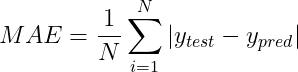

- This is the average of the absolute differences between the predicted and actual values. It measures the average magnitude of errors in a set of predictions, without considering their direction. It's less sensitive to outliers compared to MSE and RMSE.

### Mean Squared Error (MSE): 

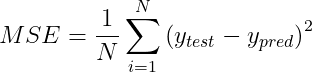

This is the average of the squared differences between the predicted and actual values. It gives more weight to larger errors (due to squaring), making it more sensitive to outliers compared to MAE.


### Root Mean Squared Error (RMSE): 



This is the square root of the MSE. It measures the standard deviation of the residuals (prediction errors). Like MSE, it gives more weight to larger errors. Its unit is the same as the original target, making it easier to interpret compared to MSE.

In summary, 
- MAE is useful when you want to understand the average magnitude of errors, without giving too much weight to outliers. 
- MSE and RMSE are useful when larger errors are particularly undesirable. 
- MAE and RMSE can be interpreted in the same units as the original target.

for more info on validation metrics, see: 

https://medium.com/@h.jurza/mastering-validation-metrics-evaluate-your-models-like-a-pro-4fda25abe3cb


In [109]:
# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error
rmse = np.sqrt(mse)

print(f"MAE: {round(mae, 2)}")
print(f"MSE: {round(mse, 2)}")
print(f"RMSE: {round(rmse, 2)}")

MAE: 2.86
MSE: 15.24
RMSE: 3.9


### R-squared Score

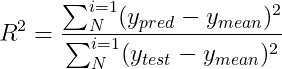

The R-squared score, also known as the coefficient of determination, is a statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variables in a regression model.

The R-squared score ranges from 0 to 1, with 1 indicating that the model explains all the variability of the response data around its mean. It provides a measure of how well the model's predictions fit the actual data.

In our case, the R-squared score is calculated as follows:

In [110]:
# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)

print(f"R-squared: {r2}")

R-squared: 0.8240562394242988


# 3 Fitting a Linear Regression Model (Method 2 - Statsmodels)

In this section, we will doing the same Linear Regression using an alternative package: `statsmodels`. 

`Statsmodels` is a package built specifically for statistics and is excellent for estimating and testing statistical models.

**Benefits of using Statsmodels**

1. **Detailed Statistical Summary**: One of the main advantages of `statsmodels` is that it provides a comprehensive statistical summary which includes useful statistics like the R-squared value, the standard error, and the confidence intervals of the coefficients. This makes it a great tool for statistical analysis and interpretation.

2. **Formula Notation**: `Statsmodels` supports R-style formula notation via the `patsy` library. This can be a more intuitive way to specify your models if you're coming from a statistics background or are used to R's syntax.

3. **Advanced Statistical Tests**: `Statsmodels` includes many built-in functions for advanced statistical testing, like ANOVA tests, which are not available in `sklearn`.

**Drawbacks of using Statsmodels**

1. **Less User-Friendly API**: Compared to `sklearn`, `statsmodels` has a less user-friendly API. It requires manually adding a constant to the independent variables for linear regression, which is not required in `sklearn`.

2. **Less Support for Machine Learning**: While `statsmodels` is great for statistical analysis, it has less support for machine learning tasks compared to `sklearn`. It doesn't have built-in functions for things like cross-validation or pipelines, which are commonly used in machine learning workflows.

3. **Less Community Support**: `Statsmodels` is less widely used than `sklearn`, which means there's less community support and fewer resources available online.
 

In [126]:
# Add a constant to the independent variable
X_encoded_sm = sm.add_constant(X_encoded)

# Perform the linear regression
model_sm = sm.OLS(y, X_encoded_sm)
result = model_sm.fit()

# Print out the statistics
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     663.3
Date:                Thu, 01 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:45:53   Log-Likelihood:                -8268.0
No. Observations:                2938   AIC:                         1.658e+04
Df Residuals:                    2917   BIC:                         1.670e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In the above results, we can also find metrics such as R-Squared and Adjusted R-Squared, as well as the listing of the features and their respective coefficients

- It is standard practice to use the coefficient p-values to decide whether to include variables in the final model.

For more info see:
https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/

## 3.1 Feature Importance Analysis

In this section, we analyse the importance of each feature in our linear regression model. The importance of a feature can be determined by the absolute value of its coefficient in the model. The larger the absolute value, the more impact the feature has on the prediction.

By analysing the feature importances, we can gain insights into which features are the most influential in predicting the target variable. This can be useful for understanding the model and for feature selection.

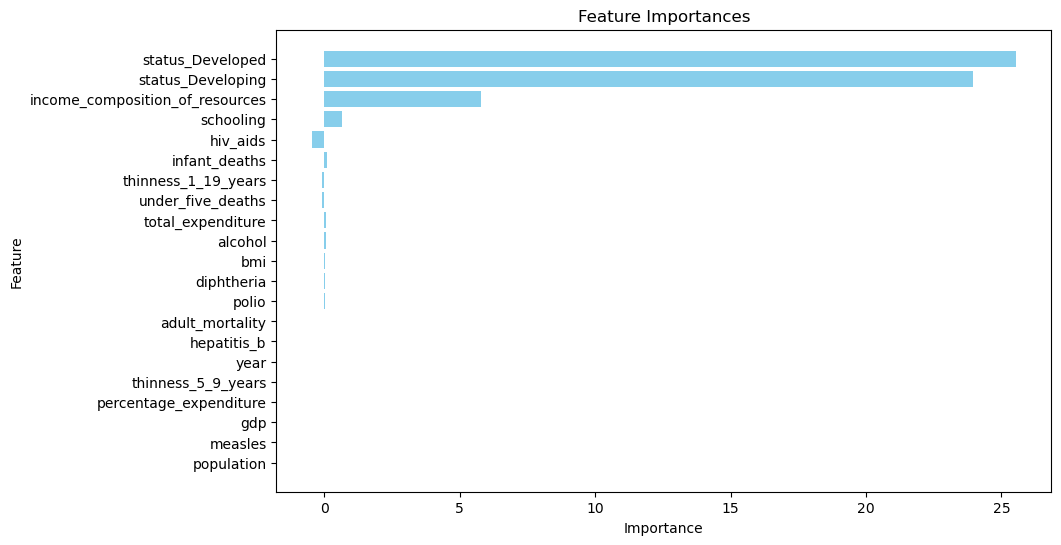

In [127]:
# Get the coefficients of the features
coefficients = result.params

# Create a dataframe of coefficients for easy viewing
# Remove the 'const' feature
feature_importance = feature_importance[feature_importance['Feature'] != 'const']

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

# 4. Summary and Recap

In this notebook, we've walked through the process of implementing a linear regression model, using a specific example for context. Each step, from data preprocessing to model training and evaluation, has been thoroughly explained to provide a clear understanding of how linear regression works.

The steps we've covered include:

1. **Data Preprocessing**: We've prepared our data for the model, which involved cleaning the data, handling missing values, and possibly encoding categorical variables.

2. **Feature Selection**: We've selected the most relevant features for our model. This is a crucial step as the performance of the model heavily relies on the quality of the variables it's fed.

3. **Model Creation and Training**: We've created a linear regression model using the `scikit-learn` and `statsmodels` libraries and trained it on our data. 

4. **Evaluation**: We've evaluated the performance of our model using appropriate metrics and visualisations.

5. **Feature Importance Analysis**: We've analszed the importance of each feature in our model, providing insights into which features are the most influential in predicting the target variable.

Below is a consolidated version of the code encompassing all the steps we've undertaken. This serves as a template that you can utilize and adapt in your own projects when implementing a linear regression model.

We can also further modularise the code by defining functions to calculate validation metrics and feature importances.

### 4.1 Data Pre-processing and Functions
We can also further modularise the code by defining functions to calculate validation metrics and feature importances.

In [169]:
def preprocess_data(df, feature_variables, target_variable):
    """
    Preprocess the data: convert types, impute missing values, define target and feature variables, 
    one-hot encode categorical variables, and split the data into training and testing sets.

    Parameters:
    df (DataFrame): The original dataframe.
    feature_variables (list): The list of feature variables.
    target_variable (str): The target variable.

    Returns:
    X_train, X_test, y_train, y_test: Training and testing data.
    """
    # Convert the 'year' field from float to int
    df['year'] = df['year'].astype('int')

    # Update our categorical and numeric variable lists as we will use them later
    num_vars = df.select_dtypes(include=['float64', 'int64']).columns
    cat_vars = df.select_dtypes(include=['object']).columns

    # Impute missing values in categorical columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_vars] = cat_imputer.fit_transform(df[cat_vars])

    # Impute missing values in numerical columns
    num_imputer = SimpleImputer(strategy='mean')
    df[num_vars] = num_imputer.fit_transform(df[num_vars])

    # Split the data into features (X) and target (y)
    X = df[feature_variables]
    y = df[target_variable]

    # One-hot encode the 'status' feature
    X_encoded = pd.get_dummies(X, drop_first=False)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test
    
def calculate_metrics(y_test, y_pred):
    """
    Calculate and print the MAE, MSE, RMSE, and R-squared score of the model's predictions.

    Parameters:
    y_test (Series or array-like): The actual target values.
    y_pred (Series or array-like): The predicted target values.

    Returns:
    None
    """
    # Calculate the Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate the Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mse)

    # Calculate the R-squared score
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {round(mae, 2)}")
    print(f"MSE: {round(mse, 2)}")
    print(f"RMSE: {round(rmse, 2)}")
    print(f"R-squared: {round(r2, 3)}")

def plot_feature_importances(result):
    """
    Plot the feature importances of a trained model.

    Parameters:
    model (statsmodels.regression.linear_model.RegressionResultsWrapper): The trained model.

    Returns:
    None
    """
    # Get the coefficients of the features
    coefficients = result.params

    # Create a dataframe of coefficients for easy viewing
    feature_importance = pd.DataFrame({'Feature': coefficients.index, 'Importance': coefficients.values})

    # Remove the 'const' feature
    feature_importance = feature_importance[feature_importance['Feature'] != 'const']

    # Sort the DataFrame by 'Importance' in descending order
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
    plt.show()

### 4.2 Linear regression using scikit-learn

In [171]:
# Data Prep
#===================================

# Read data
df = pd.read_csv('data/Life Expectancy Data.csv')

# Format dataframe columns to be lowercase and separated by underscores (for visual consistency)
df = format_dataframe_columns(df)

# Define target variable
target_variable = 'life_expectancy'

# Define feature variables
feature_variables = [
    'year',
    'status', 
    'adult_mortality',
    'infant_deaths', 
    'alcohol', 
    'percentage_expenditure', 
    'hepatitis_b',
    'measles', 
    'bmi', 
    'under_five_deaths', 
    'polio', 
    'total_expenditure',
    'diphtheria',
    'hiv_aids',
    'gdp',
    'population',
    'thinness_1_19_years',
    'thinness_5_9_years',
    'income_composition_of_resources',
    'schooling'
    ]

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(
    df=df, 
    feature_variables=feature_variables, 
    target_variable=target_variable
    )

# Linear Regression model using scikit-learn
#============================================

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_sk = model.predict(X_test)

# Calculate valiadation metrics using our custom function:
calculate_metrics(y_test, y_pred_sk)


MAE: 2.86
MSE: 15.24
RMSE: 3.9
R-squared: 0.824


In [168]:
X_train

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,status_Developed,status_Developing
456,2007,126.0,0.0,5.28,345.463714,96.000000,0.0,25.5,0.0,98.0,4.30,98.0,0.6,3112.285712,4.864380e+05,8.1,8.0,0.602,11.9,0,1
462,2001,152.0,0.0,3.81,150.743486,80.940461,0.0,22.1,0.0,91.0,5.19,9.0,0.8,1268.884564,4.437160e+05,9.4,9.3,0.562,11.0,0,1
2172,2011,143.0,0.0,10.43,0.000000,99.000000,0.0,44.5,0.0,99.0,7.58,99.0,0.1,7483.158469,1.275338e+07,4.3,4.3,0.733,12.9,0,1
2667,2013,13.0,3.0,1.29,594.645310,98.000000,16.0,59.3,3.0,98.0,7.26,98.0,0.1,4199.472530,1.114558e+06,6.4,6.3,0.720,14.7,0,1
381,2002,95.0,0.0,0.13,941.703687,99.000000,0.0,28.0,0.0,99.0,3.40,94.0,0.1,16846.219800,1.275338e+07,6.7,6.1,0.820,13.3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,2011,59.0,0.0,6.91,3601.287457,82.000000,3.0,68.0,0.0,96.0,9.60,96.0,0.1,22821.847000,4.162680e+05,0.8,0.7,0.826,14.8,1,0
1095,2010,287.0,4.0,3.21,53.307827,83.000000,26.0,23.1,7.0,82.0,6.70,83.0,5.9,543.957418,1.555880e+05,8.0,7.9,0.405,8.9,0,1
1130,2007,266.0,17.0,6.08,56.778587,80.940461,0.0,4.7,23.0,62.0,5.56,63.0,2.7,615.819819,9.556889e+06,4.2,4.2,0.458,8.4,0,1
1294,2003,72.0,2.0,9.30,3519.258515,95.000000,10982.0,57.0,3.0,97.0,8.17,96.0,0.1,27387.225800,5.731323e+06,0.5,0.5,0.841,15.4,1,0


### 4.3 Linear Regression model using statsmodels

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     524.2
Date:                Thu, 01 Feb 2024   Prob (F-statistic):               0.00
Time:                        21:53:47   Log-Likelihood:                -6635.1
No. Observations:                2350   AIC:                         1.331e+04
Df Residuals:                    2329   BIC:                         1.343e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

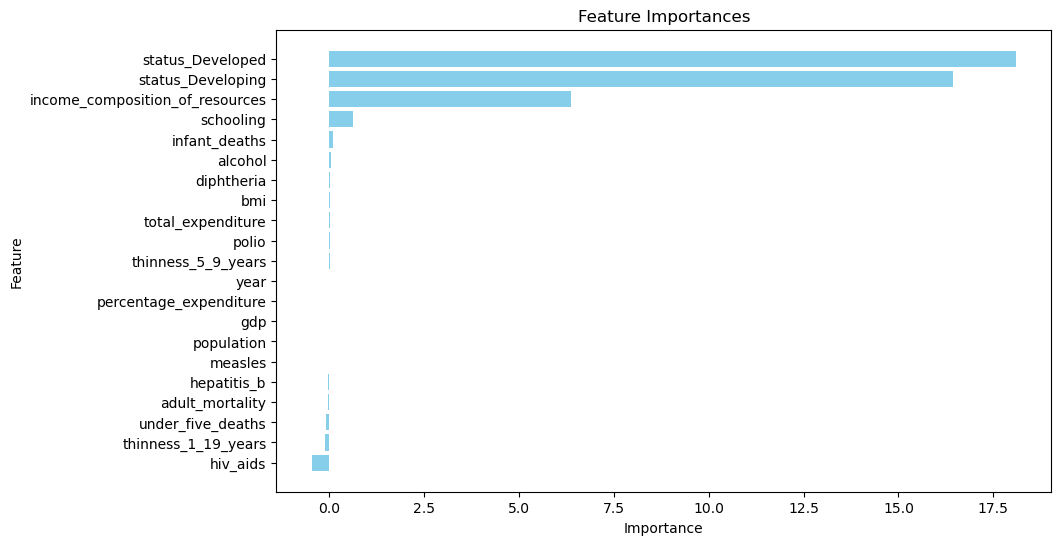

In [188]:
# Data Prep
#===================================

# Read data
df = pd.read_csv('data/Life Expectancy Data.csv')

# Format dataframe columns to be lowercase and separated by underscores (for visual consistency)
df = format_dataframe_columns(df)
# Define target variable
target_variable = 'life_expectancy'

# Define feature variables
feature_variables = [
    'year',
    'status', 
    'adult_mortality',
    'infant_deaths', 
    'alcohol', 
    'percentage_expenditure', 
    'hepatitis_b',
    'measles', 
    'bmi', 
    'under_five_deaths', 
    'polio', 
    'total_expenditure',
    'diphtheria',
    'hiv_aids',
    'gdp',
    'population',
    'thinness_1_19_years',
    'thinness_5_9_years',
    'income_composition_of_resources',
    'schooling'
    ]

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(
    df=df, 
    feature_variables=feature_variables, 
    target_variable=target_variable
    )

# Linear Regression model using statsmodels
#============================================

# Perform the linear regression
# Add a constant term to the independent variable
model_sm = sm.OLS(y_train, sm.add_constant(X_train))
result = model_sm.fit()

# Make predictions
y_pred_sm = result.predict(sm.add_constant(X_test))

# Print out the statistics
print(result.summary())

# Calculate valiadation metrics using our custom function:
calculate_metrics(y_test, y_pred_sm)

# Plot feature importances using our custom function:
plot_feature_importances(result)

# 5. Enhancing Model Performance with Feature Selection

Feature selection is a crucial step in machine learning that involves choosing relevant features for model construction. It can enhance model performance and prevent issues like overfitting.

### Why Feature Selection?

1. **Simplicity**: Fewer features simplify the model, making it easier to interpret.
2. **Efficiency**: Less features speed up model training, especially with large datasets.
3. **Overfitting Prevention**: Removing irrelevant features helps prevent overfitting.
4. **Accuracy**: Removing irrelevant features can sometimes improve model accuracy.
5. **Relevance**: Feature selection filters out noise, leading to more meaningful insights.
6. **Dimensionality Reduction**: Feature selection helps mitigate the "curse of dimensionality" in high-dimensional data.

Two common feature selection methods are:

**Backward Elimination**

This method starts with all features and iteratively removes the least significant one until model performance decreases. Steps are:

1. Choose a significance level (e.g., SL = 0.05).
2. Fit the model with all predictors.
3. If the predictor with the highest p-value > SL, go to the next step. Otherwise, the model is ready.
4. Remove the predictor.
5. Fit the model without this variable.
6. Repeat steps 3-5 until all predictors have a p-value <= SL.

**Forward Selection**

This method starts with no features and adds them one by one, each time choosing the one that most improves the model. Steps are:

1. Choose a significance level (e.g., SL = 0.05).
2. Fit all simple regression models and select the one with the lowest p-value.
3. Keep this variable and fit all models with one extra predictor.
4. If the predictor with the lowest p-value < SL, go to the next step. Otherwise, the model is ready.
5. Keep the predictor and repeat steps 3-4 until all predictors have a p-value >= SL.

Both methods aim to simplify models and prevent overfitting. They can yield different results, so it's often beneficial to try different feature selection methods for your specific use case.

## 5.1 Manual feature selection

Experiment by commenting out specific features (based on their p-values) to see how they affect regression results. 
- Try both backward elimination and forward selection

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     699.7
Date:                Thu, 01 Feb 2024   Prob (F-statistic):               0.00
Time:                        21:57:41   Log-Likelihood:                -6636.1
No. Observations:                2350   AIC:                         1.330e+04
Df Residuals:                    2334   BIC:                         1.340e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

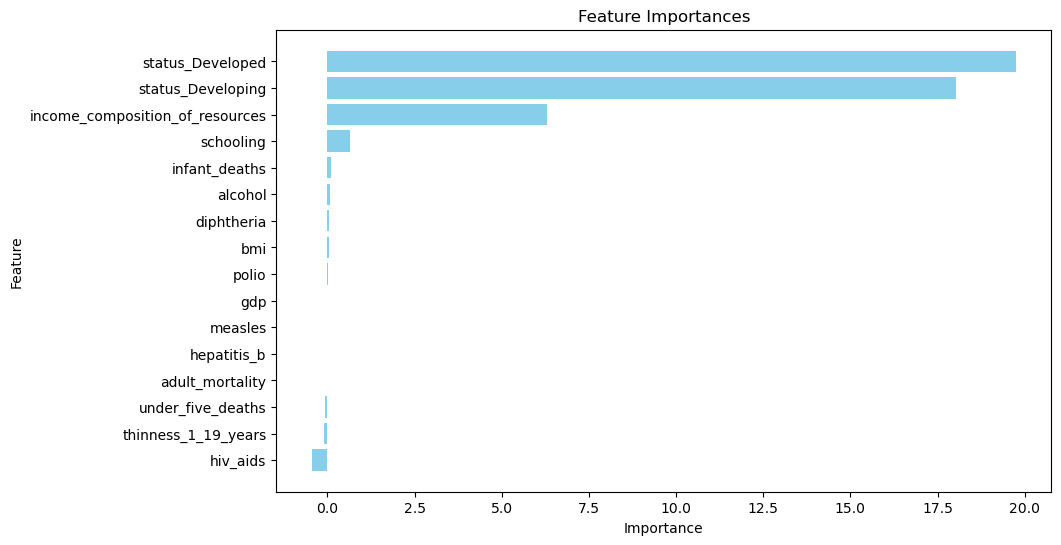

No variable has a p-value over the significance level.


In [193]:
# Data Prep
#===================================

# Read data
df = pd.read_csv('data/Life Expectancy Data.csv')

# Format dataframe columns to be lowercase and separated by underscores (for visual consistency)
df = format_dataframe_columns(df)
# Define target variable
target_variable = 'life_expectancy'

# Define feature variables
feature_variables = [
    # 'year',
    'status', 
    'adult_mortality',
    'infant_deaths', 
    'alcohol', 
    # 'percentage_expenditure', 
    'hepatitis_b',
    'measles', 
    'bmi', 
    'under_five_deaths', 
    'polio', 
    # 'total_expenditure',
    'diphtheria',
    'hiv_aids',
    'gdp',
    # 'population',
    'thinness_1_19_years',
    # 'thinness_5_9_years',
    'income_composition_of_resources',
    'schooling'
    ]

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(
    df=df, 
    feature_variables=feature_variables, 
    target_variable=target_variable
    )

# Linear Regression model using statsmodels
#============================================

# Perform the linear regression
# Add a constant term to the independent variable
model_sm = sm.OLS(y_train, sm.add_constant(X_train))
result = model_sm.fit()

# Make predictions
y_pred_sm = result.predict(sm.add_constant(X_test))

# Print out the statistics
print(result.summary())

# Calculate valiadation metrics using our custom function:
calculate_metrics(y_test, y_pred_sm)

# Plot feature importances using our custom function:
plot_feature_importances(result)

def get_highest_p_value(result, significance_level):
    
    # Get the summary table
    summary_table = result.summary2().tables[1]

    # Get the variable with the highest p-value
    highest_pvalue_variable = summary_table['P>|t|'].idxmax()
    highest_pvalue = summary_table['P>|t|'].max()

    # Check if the highest p-value is over the significance level
    if highest_pvalue > significance_level:
        print(f"Variable with the highest p-value (over the significance level) is: \n{highest_pvalue_variable} \twith p-value: {highest_pvalue}")
    else:
        print("No variable has a p-value over the significance level.")

get_highest_p_value(result=result, significance_level=0.05)

## Note on feature selection:

When you remove features with high p-values from your model, you are essentially simplifying your model by reducing its complexity. This is based on the premise that those features are not statistically significant in predicting the target variable, as indicated by their high p-values.

However, removing these features can sometimes lead to a decrease in the R-squared value. The R-squared value is a measure of how well the model fits the data. It represents the proportion of variance in the dependent variable that can be predicted from the independent variables. So, when you remove some variables, even if they are not statistically significant, the model might lose some of its predictive power, leading to a lower R-squared value.

Whether this is good or bad depends on your specific goals and the context:

- If your goal is to build a model that is as accurate as possible, then a decrease in R-squared might be seen as bad because it means your model's fit to the data has worsened.

- However, if your goal is to build a model that only includes statistically significant predictors, then you might be willing to accept a slight decrease in R-squared. This could be seen as good because your model is now simpler and potentially more interpretable, and it's less likely to be overfitting to the noise in the data.

In general, it's a trade-off between model complexity (including more variables for a better fit) and model simplicity (including fewer, but more significant variables for better interpretability and generalisation). 

- This is a common theme in machine learning and statistics known as the bias-variance tradeoff.

## 5.2 Automatic backward elimination

Here we use a loop to automatically remove features by the backward elimination algorithm

Removing variable: year with p-value: 0.9060459507279626
Removing variable: thinness_5_9_years with p-value: 0.7786524208873806
Removing variable: population with p-value: 0.6950372656186445
Removing variable: percentage_expenditure with p-value: 0.3908454014139615
Removing variable: total_expenditure with p-value: 0.3115786173651681
No variable has a p-value over the significance level.
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     699.7
Date:                Thu, 01 Feb 2024   Prob (F-statistic):               0.00
Time:                        22:01:45   Log-Likelihood:                -6636.1
No. Observations:                2350   AIC:                         1.330e+04
Df Residuals:                    2334   BIC:            

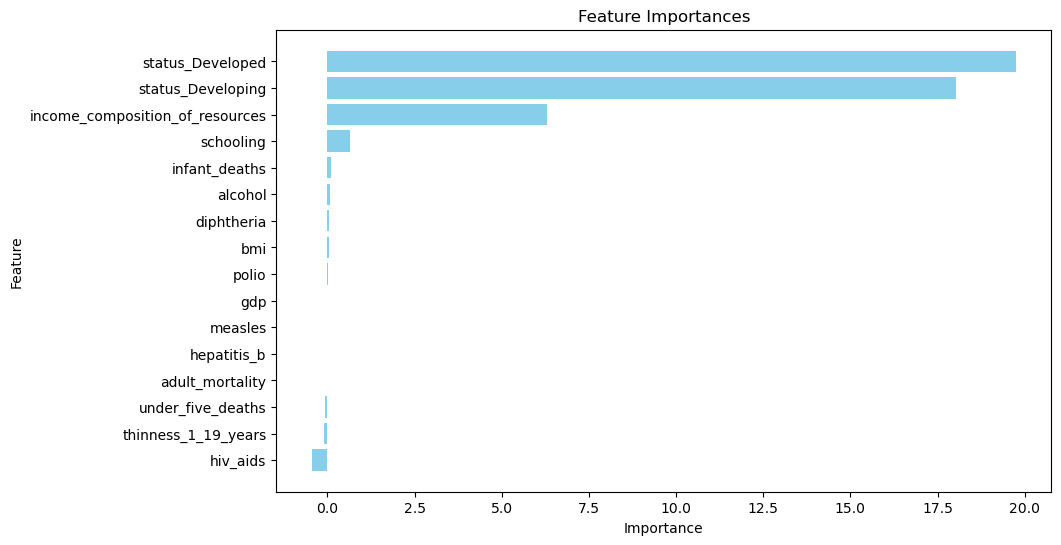

Selected features: Index(['adult_mortality', 'infant_deaths', 'alcohol', 'hepatitis_b', 'measles',
       'bmi', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 'gdp',
       'thinness_1_19_years', 'income_composition_of_resources', 'schooling',
       'status_Developed', 'status_Developing'],
      dtype='object')


In [196]:
# Data Prep
#===================================

# Read data
df = pd.read_csv('data/Life Expectancy Data.csv')

# Format dataframe columns to be lowercase and separated by underscores (for visual consistency)
df = format_dataframe_columns(df)
# Define target variable
target_variable = 'life_expectancy'

# Define feature variables
feature_variables = [
    'year',
    'status', 
    'adult_mortality',
    'infant_deaths', 
    'alcohol', 
    'percentage_expenditure', 
    'hepatitis_b',
    'measles', 
    'bmi', 
    'under_five_deaths', 
    'polio', 
    'total_expenditure',
    'diphtheria',
    'hiv_aids',
    'gdp',
    'population',
    'thinness_1_19_years',
    'thinness_5_9_years',
    'income_composition_of_resources',
    'schooling'
    ]

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(
    df=df, 
    feature_variables=feature_variables, 
    target_variable=target_variable
    )

# Linear Regression model using statsmodels
#============================================

# Define significance level
significance_level = 0.05

# Perform the linear regression with backward elimination
while True:
    # Add a constant term to the independent variable
    model_sm = sm.OLS(y_train, sm.add_constant(X_train))
    result = model_sm.fit()

    # Get the summary table
    summary_table = result.summary2().tables[1]

    # Get the variable with the highest p-value
    highest_pvalue_variable = summary_table['P>|t|'].idxmax()
    highest_pvalue = summary_table['P>|t|'].max()

    # Check if the highest p-value is over the significance level
    if highest_pvalue > significance_level:
        print(f"Removing variable: {highest_pvalue_variable} with p-value: {highest_pvalue}")
        # Remove the variable with the highest p-value
        if highest_pvalue_variable == 'const':
            print("The model's constant has a p-value over the significance level.")
            break
        else:
            X_train = X_train.drop(columns=highest_pvalue_variable)
            X_test = X_test.drop(columns=highest_pvalue_variable)
    else:
        print("No variable has a p-value over the significance level.")
        break

# Make predictions
y_pred_sm = result.predict(sm.add_constant(X_test))

# Print out the statistics
print(result.summary())

# Calculate validation metrics using our custom function:
calculate_metrics(y_test, y_pred_sm)

# Plot feature importances using our custom function:
plot_feature_importances(result)

# Print resulting selected features
print('Selected features:', X_train.columns)

## 5.2 Automatic forward-selection

Here we use a loop to automatically remove features by the forward-selection algorithm

Adding variable: year with p-value: 1.7903262457705266e-17
Adding variable: adult_mortality with p-value: 0.0
Adding variable: infant_deaths with p-value: 5.225181017116729e-22
Adding variable: alcohol with p-value: 8.093929646503404e-77
Adding variable: percentage_expenditure with p-value: 1.7420432349895395e-23
Adding variable: hepatitis_b with p-value: 1.6187155858057275e-06
Adding variable: measles with p-value: 1.5837263929625227e-09
Adding variable: bmi with p-value: 5.3966249545414895e-59
Adding variable: under_five_deaths with p-value: 5.943877714034337e-48
Adding variable: polio with p-value: 4.456850841870995e-32
Skipping variable: total_expenditure with p-value: 0.5621331602968086
Adding variable: diphtheria with p-value: 7.572606507460813e-17
Adding variable: hiv_aids with p-value: 1.2296163437937871e-87
Adding variable: gdp with p-value: 8.146786521827871e-07
Skipping variable: population with p-value: 0.6303697275240965
Adding variable: thinness_1_19_years with p-value: 1

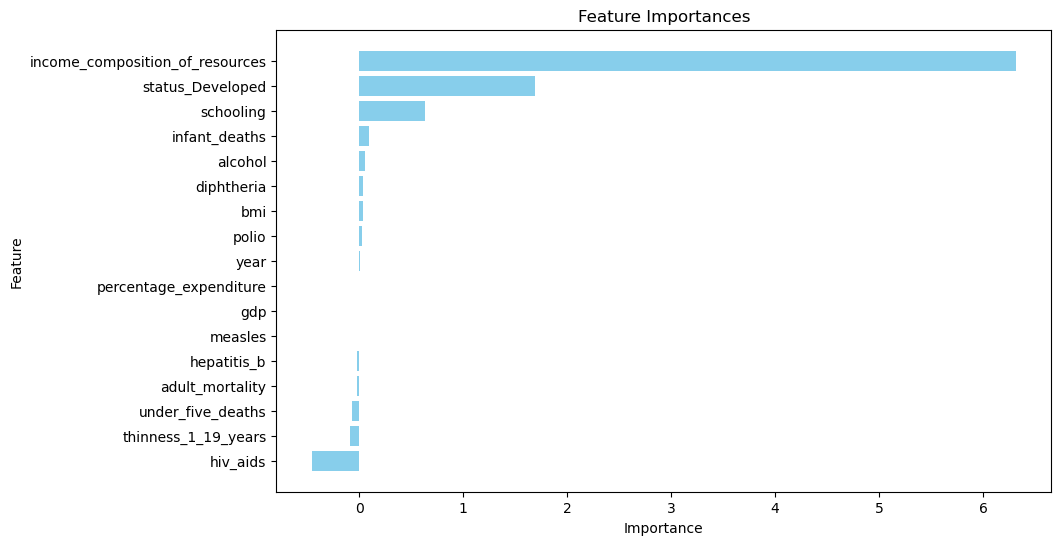

Selected features: ['year', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 'gdp', 'thinness_1_19_years', 'income_composition_of_resources', 'schooling', 'status_Developed']


In [199]:
# Data Prep
#===================================

# Read data
df = pd.read_csv('data/Life Expectancy Data.csv')

# Format dataframe columns to be lowercase and separated by underscores (for visual consistency)
df = format_dataframe_columns(df)
# Define target variable
target_variable = 'life_expectancy'

# Define feature variables
feature_variables = [
    'year',
    'status', 
    'adult_mortality',
    'infant_deaths', 
    'alcohol', 
    'percentage_expenditure', 
    'hepatitis_b',
    'measles', 
    'bmi', 
    'under_five_deaths', 
    'polio', 
    'total_expenditure',
    'diphtheria',
    'hiv_aids',
    'gdp',
    'population',
    'thinness_1_19_years',
    'thinness_5_9_years',
    'income_composition_of_resources',
    'schooling'
    ]

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(
    df=df, 
    feature_variables=feature_variables, 
    target_variable=target_variable
    )

# Linear Regression model using statsmodels
#============================================

# Define significance level
significance_level = 0.05

# Initialize selected features
selected_features = []

# Perform the linear regression with forward selection
for feature in X_train.columns:
    # Add a constant term to the independent variable
    X_train_temp = sm.add_constant(X_train[selected_features + [feature]])
    model_sm = sm.OLS(y_train, X_train_temp)
    result = model_sm.fit()

    # Get the summary table
    summary_table = result.summary2().tables[1]

    # Get the p-value of the added feature
    pvalue = summary_table.loc[feature, 'P>|t|']

    # Check if the p-value is under the significance level
    if pvalue < significance_level:
        print(f"Adding variable: {feature} with p-value: {pvalue}")
        # Add the variable to the selected features
        selected_features.append(feature)
    else:
        print(f"Skipping variable: {feature} with p-value: {pvalue}")

# Fit the model with the selected features
X_train_selected = sm.add_constant(X_train[selected_features])
model_sm = sm.OLS(y_train, X_train_selected)
result = model_sm.fit()

# Make predictions
X_test_selected = sm.add_constant(X_test[selected_features])
y_pred_sm = result.predict(X_test_selected)

# Print out the statistics
print(result.summary())

# Calculate validation metrics using our custom function:
calculate_metrics(y_test, y_pred_sm)

# Plot feature importances using our custom function:
plot_feature_importances(result)

# Print resulting selected features
print('Selected features:', selected_features)